# Table of Contents
1. [download/read csv file](#sec1)
2. [Convert the labeled data set tags into the new individual tag columns](#sec2)
3. [NLTK](#sec3)
4. [Classifier Building](#sec4)
5. [Frequency Visualizations and Heatmaps](#sec5)
7. [FIS Score](#sec6)

In [50]:
#packages
#%pip install numpy
#%pip install pandas
import numpy as np
import pandas as pd

<a id = "sec1"></a>
## **Download/Read CSV file**

In [51]:
# read csv
github_csv_url = "https://raw.githubusercontent.com/JL72005/PIT-UN-Project4/refs/heads/main/NEW_TAGS_dc_md_va_flash_floods_1996_present.xlsx%20-%20dc_md_va_flash_floods_1996_pres.csv?token=GHSAT0AAAAAADCLZGCQEFCRWKI4KDKRV3DE2CDCQMQ"
df = pd.read_csv(github_csv_url)
# print first 5 rows
print(df.head())
# print column names
print(df.columns)

   BEGIN_YEARMONTH  BEGIN_DAY  BEGIN_TIME  END_YEARMONTH  END_DAY  END_TIME  \
0           199601         19        1100         199601       19      1300   
1           199606         18          30         199606       18       200   
2           199606         20        2200         199606       20      2300   
3           199609          6        1200         199609        6      1800   
4           199611          8        1600         199611        8      1715   

   EPISODE_ID  EVENT_ID                 STATE  STATE_FIPS  ...  END_LOCATION  \
0     2403644   5541358  DISTRICT OF COLUMBIA          11  ...           ALL   
1     1014286   5561204  DISTRICT OF COLUMBIA          11  ...     N PORTION   
2     2040906   5561207  DISTRICT OF COLUMBIA          11  ...     NORTHWEST   
3     2049837   5572405  DISTRICT OF COLUMBIA          11  ...      DOWNTOWN   
4     2049872   5572790  DISTRICT OF COLUMBIA          11  ...      CITYWIDE   

  BEGIN_LAT BEGIN_LON END_LAT  END_LON  \
0 

<a id = "sec2"></a>
## **Convert the labeled data set tags into the new individual tag columns**

In [52]:
#list of tags
tag_names = ['death','injury','evacuation','rescue','car_crash','home_damage','infrastructure_damage','soft_infrastructure_damage','road_closure','power_outage','tree_damage','vehicle_loss','agricultural_damage','campground_damage']
#list of weather events
weather_names = ['nor_easter','thunderstorm','hurricane','tornado','lightning','mudslide']

In [53]:
#remove empty rows where event narrative and episode narrative are both empty
df=df.dropna(subset=['EVENT_NARRATIVE', 'EPISODE_NARRATIVE'], how='all')
# Populate columns for OG tags
for tag in tag_names:
    df[tag] = 0  # Initialize column as int
    df.loc[0:906, tag] = df.loc[0:906, 'IMPACT_PREDICTORS'].apply(str).apply(lambda x: 1 if tag in x else 0)

# Populate columns for weather-related tags
for tag in weather_names:
    df[tag] = df['weather_events'].apply(str).apply(lambda x: 1 if tag in x else 0).astype(int)


In [54]:
#check columns
#df[tag_names + weather_names].head(15)
df.loc[300:310, tag_names + weather_names].head(10)

,death,injury,evacuation,rescue,car_crash,home_damage,infrastructure_damage,soft_infrastructure_damage,road_closure,power_outage,tree_damage,vehicle_loss,agricultural_damage,campground_damage,nor_easter,thunderstorm,hurricane,tornado,lightning,mudslide
300,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0
301,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0
302,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0
303,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0
304,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0
305,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0
306,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0
307,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0
308,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0
309,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0


<a id="sec3"></a>
## **NLTK**

In [55]:
#imports
#%pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

### Tokenization and Stop Word Removal

In [56]:
#download necessary NLTK data
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopword(text):
  '''Tokenizes the given text, removes all stopwords, and makes everything lowercase.
  - text: str

  Returns: str of the processed text.
  '''
  tk = RegexpTokenizer(r'\w+')
  word_tokens = tk.tokenize(text) #tokenize
  filtered_sentence = [w.lower() for w in word_tokens if not w.lower() in stop_words] #remove stopwords / make lowercase
  filtered_text = " ".join(filtered_sentence)
  return filtered_text

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
#tokenize the narratives
df['TOKEN_EPISODE_NARRATIVE'] = df['EPISODE_NARRATIVE'].apply(str).apply(remove_stopword)
df['TOKEN_EVENT_NARRATIVE'] = df['EVENT_NARRATIVE'].apply(str).apply(remove_stopword)
df[['TOKEN_EPISODE_NARRATIVE', 'TOKEN_EVENT_NARRATIVE']].head() #view data

,TOKEN_EPISODE_NARRATIVE,TOKEN_EVENT_NARRATIVE
0,unusually intense squall line feeding unseason...,nan
1,intense thunderstorms moved northeast half was...,nan
2,rapidly developing thunderstorm knocked numero...,nan
3,feeder bands torrential tropical rains associa...,nan
4,several roads briefly closed torrential rains ...,nan


### Stemming

In [58]:
# STEMMING (not used)

stemmer = PorterStemmer()

def stem_narrative(text):
    token_list = text.split(" ")
    stemmed_list = []
    for word in token_list:
        stemmed_list.append(stemmer.stem(word))
    return stemmed_list

df['STEM_EPISODE_NARRATIVE'] = df['TOKEN_EPISODE_NARRATIVE'].apply(str).apply(stem_narrative).apply(lambda x: " ".join(x)) #where x is the list of stemmed words
df['STEM_EVENT_NARRATIVE'] = df['TOKEN_EVENT_NARRATIVE'].apply(str).apply(stem_narrative).apply(lambda x: " ".join(x)) #where x is the list of stemmed words
df['STEM_EPISODE_NARRATIVE'].head()


0    unusu intens squall line feed unseason warm mo...
1    intens thunderstorm move northeast half washin...
2    rapidli develop thunderstorm knock numer tree ...
3    feeder band torrenti tropic rain associ remnan...
4    sever road briefli close torrenti rain associ ...
Name: STEM_EPISODE_NARRATIVE, dtype: object

### Lemmatization: Reducing word to base form

In [59]:
#import necessary NLTK data
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk import pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')

lemmatizer = WordNetLemmatizer()

# Helper: Convert NLTK POS tag to WordNet POS
def get_wordnet_pos(word):
    '''Converts the NLTK POS tag of the given word to its WordNet POS tag counterpart.
    - word: str

    Returns: str representing the WordNet POS
    '''
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN) 

def lemmatize_narrative(text):
    '''Lemmatizes the given text.
    - text: str

    Returns: str of the lemmatized text.
    '''
    token_list = text.split()
    lemmatized_list = []
    for word in token_list:
        pos = get_wordnet_pos(word) #gets WordNet POS
        lemmatized_list.append(lemmatizer.lemmatize(word,pos)) #lemmatizes
    lemmatized_sentence = " ".join(lemmatized_list)
    return lemmatized_sentence

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [60]:
#lemmatize the narratives
df= df.fillna('')  # Fill NaN values with empty strings to avoid errors in lemmatization
df['LEM_EPISODE_NARRATIVE'] = df['TOKEN_EPISODE_NARRATIVE'].apply(str).apply(lemmatize_narrative)
df['LEM_EVENT_NARRATIVE'] = df['TOKEN_EVENT_NARRATIVE'].apply(str).apply(lemmatize_narrative)
df["combo_narrative"] = df["LEM_EPISODE_NARRATIVE"].astype(str) + " " + df["LEM_EVENT_NARRATIVE"].astype(str) #combine narratives for easier tagging
df[['LEM_EPISODE_NARRATIVE', 'LEM_EVENT_NARRATIVE']].head()

,LEM_EPISODE_NARRATIVE,LEM_EVENT_NARRATIVE
0,unusually intense squall line feed unseasonabl...,nan
1,intense thunderstorm move northeast half washi...,nan
2,rapidly develop thunderstorm knock numerous tr...,nan
3,feeder band torrential tropical rain associate...,nan
4,several road briefly close torrential rain ass...,nan


<a id ="sec4"></a>
## **Classifier Building**

### Corpus Creation

In [61]:
#take spreadsheet of tags and their key words and generate a list/corpus for every tag
#download necessary NLTK data
import csv
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')

lemmatizer2 = WordNetLemmatizer()

#convert corpus CSV into a dictionary, and lemmatize
with open('tag_corpus.csv','r') as inputFile:
    data = csv.DictReader(inputFile)
    tag_corpus = {row['Tag']: row['Similar Words'].split(', ') for row in data} #setup dictionary
    for tag in tag_corpus:
        for i in range(len(tag_corpus[tag])): #for each "synonym" in a given corpus
            word = tag_corpus[tag][i].strip()
            pos = get_wordnet_pos(word)
            tag_corpus[tag][i] = lemmatizer.lemmatize(word, pos)
        tag_corpus[tag] = list(set(tag_corpus[tag])) #removes duplicates
        print(f"{tag}: {tag_corpus[tag]}")

death: ['swept away', 'drowns', 'casualty', 'death', 'fatal', 'perish', 'lifeless', 'fatality', 'casualities', 'die', 'drown', 'dead']
injury: ['treated and released from Army community hospital', 'wound', 'hurt', 'harm', 'injury', 'injured']
evacuation: ['isolated', 'forced out', 'displace', 'relocate', 'climbed to safety', 'strand', 'evacuate', 'evacuation', 'moved out']
rescue: ['retrieval', 'retrieve', 'save', 'rescue']
car_crash: ['collision', 'car crash', 'wreck', 'accident', 'crash', 'crashed', 'vehicle accident']
home_damage: ['flooded home', 'flooded house', 'property damage', 'shingle', 'basement flooded', 'fence', 'home damage', 'house', 'garage', 'residence damage', 'mobile home parks', 'home destroyed', 'home', 'mobile homes', 'residential gardens', 'roof', 'gutter', 'side', 'mailbox', 'house damage', 'dwelling', 'residence', 'windows,chimneys', 'porch', 'roof collapse', 'apartment buildings', 'shed']
infrastructure_damage: ['mezzanine and platform levels', 'pumping statio

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


### Create Function that adds these tags

In [62]:
def label_tag(text, tag): 
    '''Determines whether the given text should be labeled with the given tag.
    - text: str
    - tag: str

    Returns: int where 1 represents a label, and 0 represents no label
    '''
    for syns in tag_corpus[tag]: #the list in the tag 
        if syns in text: #if the text is in the list
            return int(1)
    return int(0)


### Apply The Function to our sets

#### Applying to Testing Dataset and remaining data

In [63]:
# apply the label_tag function to each row in the dataframe for each tag
df2 = df.copy()  # Create a copy of the original dataframe to avoid modifying it directly
for tag in tag_corpus:
    #extract the information from EVENT and EPISODE NARRATIVE columns
    df2["combo_narrative"] = df2["LEM_EPISODE_NARRATIVE"].astype(str) + " " + df2["LEM_EVENT_NARRATIVE"].astype(str)
    df2.loc[0:908, tag] = df2.loc[0:908, "combo_narrative"].apply(lambda text: label_tag(text, tag)).astype(int)
    df2.loc[908:, tag] = df2.loc[908:, "combo_narrative"].apply(lambda text: label_tag(text, tag)).astype(int)


#### Compute the accuracy - Jessica 

In [64]:
for tag in tag_names + weather_names:
    '''if tag not in df.columns or tag not in df2.columns: 
        print(f"Tag: {tag} not found in one of the dataframes, skipping.")
        continue'''
    match_rate = (df.loc[0:908, tag] == df2.loc[0:908, tag]).mean() * 100 #computing accuracy for only the testing data
    print(f"Tag: {tag} | Accuracy: {match_rate:.2f}%")


Tag: death | Accuracy: 95.34%
Tag: injury | Accuracy: 96.60%
Tag: evacuation | Accuracy: 88.41%
Tag: rescue | Accuracy: 95.34%
Tag: car_crash | Accuracy: 98.61%
Tag: home_damage | Accuracy: 83.12%
Tag: infrastructure_damage | Accuracy: 26.20%
Tag: soft_infrastructure_damage | Accuracy: 88.04%
Tag: road_closure | Accuracy: 85.39%
Tag: power_outage | Accuracy: 84.63%
Tag: tree_damage | Accuracy: 81.86%
Tag: vehicle_loss | Accuracy: 78.97%
Tag: agricultural_damage | Accuracy: 98.74%
Tag: campground_damage | Accuracy: 90.81%
Tag: nor_easter | Accuracy: 100.00%
Tag: thunderstorm | Accuracy: 99.37%
Tag: hurricane | Accuracy: 99.62%
Tag: tornado | Accuracy: 100.00%
Tag: lightning | Accuracy: 96.73%
Tag: mudslide | Accuracy: 96.22%


In [65]:
# viewing thunderstorm tags (to troubleshoot accuracy)
'''thunderstorm_narratives = list(df2[["combo_narrative", "thunderstorm"]].apply(lambda x: x['combo_narrative'] if x['thunderstorm']==1 else "", axis=1))
for i in range(len(thunderstorm_narratives)):
    if not thunderstorm_narratives[i]=="":
        print(i, ": ", thunderstorm_narratives[i],"\n")'''

'thunderstorm_narratives = list(df2[["combo_narrative", "thunderstorm"]].apply(lambda x: x[\'combo_narrative\'] if x[\'thunderstorm\']==1 else "", axis=1))\nfor i in range(len(thunderstorm_narratives)):\n    if not thunderstorm_narratives[i]=="":\n        print(i, ": ", thunderstorm_narratives[i],"\n")'

<a id = "sec5"></a>
## **Visualize the Tags -Jessica and Emma** 
heatmap, frequency/barchart, co-occurence

In [66]:
#imports
#%pip install matplotlib
import matplotlib.pyplot as plt

### Frequency of Tags

In [67]:
#FREQUENCY OF TAGS
all_tags = tag_names + weather_names
tag_frequency = []
weather_frequency = []
for i in range(len(tag_names)):
    tag_frequency.append(int(df2[tag_names[i]].sum()))
for i in range(len(weather_names)):
    weather_frequency.append(int(df2[weather_names[i]].sum()))

Text(0.5, 0, 'Count')

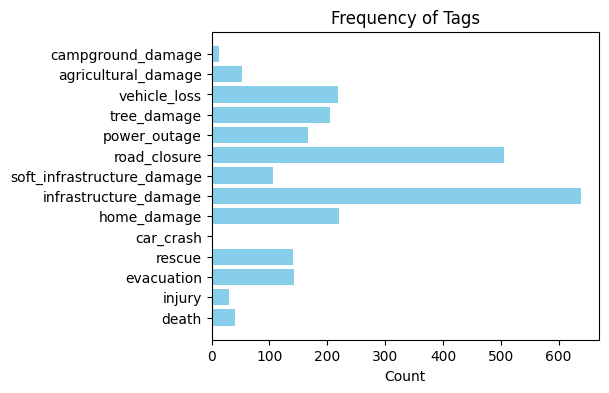

In [68]:
#BAR CHART for frequency of tags
plt.figure(figsize=(5, 4))
plt.barh(tag_names, tag_frequency, color="skyblue")
plt.title("Frequency of Tags")
plt.xlabel("Count")

Text(0.5, 0, 'Count')

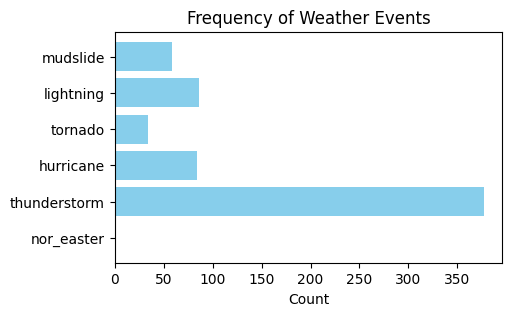

In [69]:
#BAR CHART for frequency of weather events
plt.figure(figsize=(5, 3))
plt.barh(weather_names, weather_frequency, color="skyblue")
plt.title("Frequency of Weather Events")
plt.xlabel("Count")

In [77]:
# FREQUENCY PER STATE
def state_label_frequency(state, labels):
    '''Returns a list of the counts of the specific labels for the specific state.
    - state: str
    - labels: list
    '''
    st_frequency = []
    for i in range(len(labels)):
        st_values = list(df2[["STATE",labels[i]]].apply(lambda x: x[labels[i]] if str(x["STATE"])==state else 0, axis=1))
        st_frequency.append(sum(st_values))
    return st_frequency

Text(0.5, 0, 'Count')

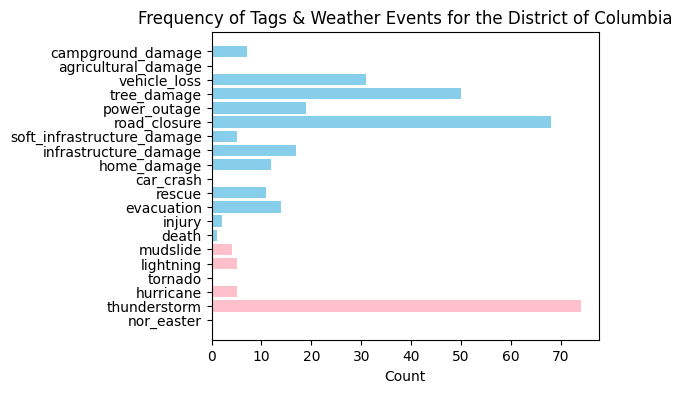

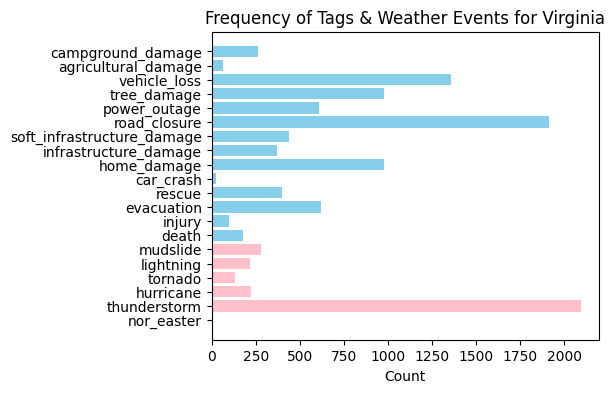

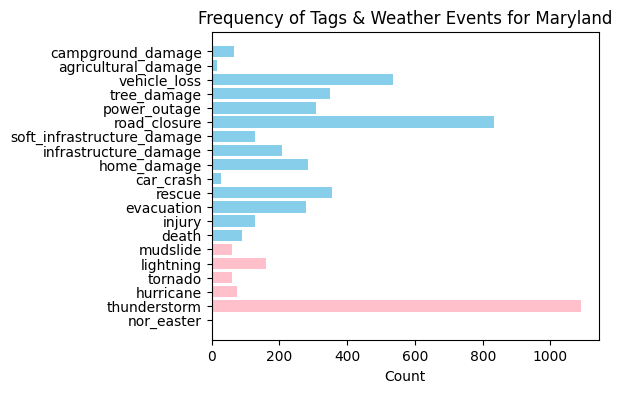

In [78]:
# FREQUENCY MAPPING FOR DC
plt.figure(figsize=(5, 4))
dc_tag_counts = state_label_frequency("DISTRICT OF COLUMBIA", tag_names)
dc_weather_counts = state_label_frequency("DISTRICT OF COLUMBIA", weather_names)
plt.barh(weather_names, dc_weather_counts, color="pink")
plt.barh(tag_names, dc_tag_counts, color="skyblue")
plt.title("Frequency of Tags & Weather Events for the District of Columbia")
plt.xlabel("Count")
# FREQUENCY MAPPING FOR VIRGINIA
plt.figure(figsize=(5, 4))
va_tag_counts = state_label_frequency("VIRGINIA", tag_names)
va_weather_counts = state_label_frequency("VIRGINIA", weather_names)
plt.barh(weather_names, va_weather_counts, color="pink")
plt.barh(tag_names, va_tag_counts, color="skyblue")
plt.title("Frequency of Tags & Weather Events for Virginia")
plt.xlabel("Count")
# FREQUENCY MAPPING FOR MARYLAND
plt.figure(figsize=(5, 4))
md_tag_counts = state_label_frequency("MARYLAND", tag_names)
md_weather_counts = state_label_frequency("MARYLAND", weather_names)
plt.barh(weather_names, md_weather_counts, color="pink")
plt.barh(tag_names, md_tag_counts, color="skyblue")
plt.title("Frequency of Tags & Weather Events for Maryland")
plt.xlabel("Count")

### Correlation Heatmaps

#### Impact vs. Impact

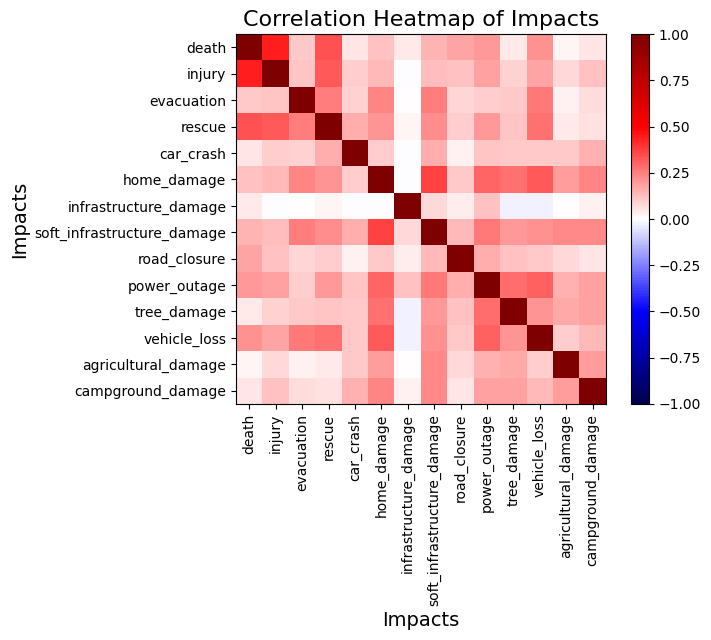

<Figure size 1000x800 with 0 Axes>

In [72]:
#heat map of the tags
all_tags = tag_names + weather_names


import seaborn as sns

# Compute correlation matrix for tag columns
corr_matrix = df2[tag_names].corr()

#heatmap of tags with tags
fig, ax = plt.subplots()
im = ax.imshow(corr_matrix, cmap='seismic', vmin=-1, vmax=1)  # Changed 'rocket' to 'RdBu'
# Add color bar
cbar = ax.figure.colorbar(im, ax=ax)
ax.set_xticks(range(len(tag_names)), labels=tag_names, rotation=90,fontsize=10)  # Rotate x-axis labels for better visibility
ax.set_yticks(range(len(tag_names)), labels=tag_names, rotation=0,fontsize=10)  # Set y-axis labels
plt.figure(figsize=(10, 8))  # Adjust figure size for better visibility
# Set title and labels
ax.set_title('Correlation Heatmap of Impacts', fontsize=16)
ax.set_xlabel('Impacts', fontsize=14)
ax.set_ylabel('Impacts', fontsize=14)
# Overlay seaborn heatmap for annotation and better visuals
#sns.heatmap(corr_matrix, cmap='Spectral', annot=True, vmin=-1, vmax=1, linewidths=0.5, linecolor='white', ax=ax)
plt.show()

#### Weather Events vs. Impact

C:\Users\jessi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\jessi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


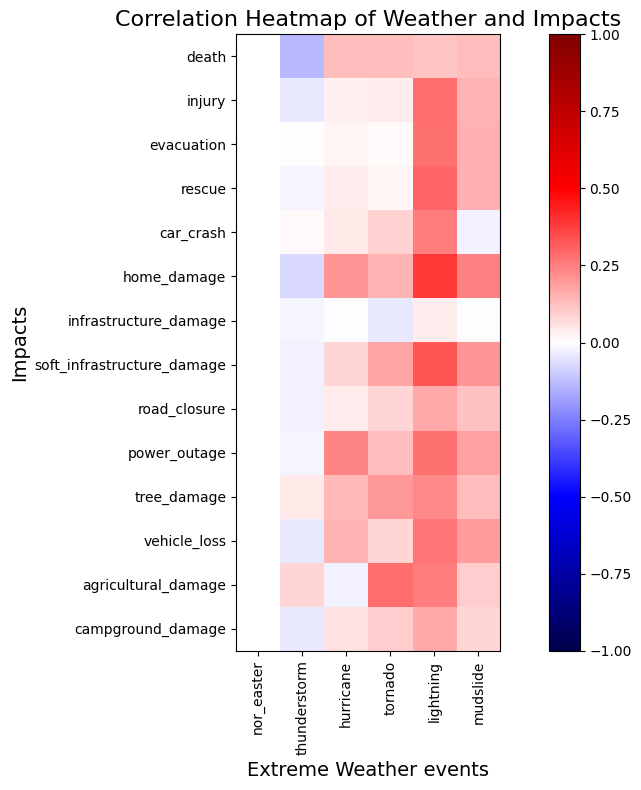

In [73]:
#heatmap of tags with weather events
import numpy as np

# Compute correlations between tag columns and weather columns
corr_matrix_weather = np.corrcoef(df2[tag_names].T, df2[weather_names].T)
# Extract submatrix (tags × weather)
n_tags = len(tag_names)
n_weather = len(weather_names)
corr_submatrix = corr_matrix_weather[:n_tags, n_tags:]  # shape: (tags, weather)

fig, ax = plt.subplots(figsize=(10, 8))  # Proper figsize set on the same figure
im = ax.imshow(corr_submatrix, cmap='seismic', vmin=-1, vmax=1)

# Colorbar
cbar = fig.colorbar(im, ax=ax)

# Set tick labels
ax.set_xticks(range(len(weather_names)))
ax.set_xticklabels(weather_names, rotation=90, fontsize=10)

ax.set_yticks(range(len(tag_names)))
ax.set_yticklabels(tag_names, rotation=0, fontsize=10)

# Titles
ax.set_title('Correlation Heatmap of Weather and Impacts', fontsize=16)
ax.set_xlabel('Extreme Weather events', fontsize=14)
ax.set_ylabel('Impacts', fontsize=14)

plt.tight_layout()
plt.show()

<a id = "sec6"></a>
## **Create FIS score - Danielle** 
We should check for multicollinearity 
on a scale of 0% to 100% --> 0 to 1

In [ ]:
weights = {
    'death': 1.0,
    'injury': 0.9,
    'evacuation': 0.8,
    'rescue': 0.8,
    'car_crash': 0.5,
    'home_damage': 0.7,
    'infrastructure_damage': 0.7,
    'soft_infrastructure_damage': 0.6,
    'road_closure': 0.4,
    'power_outage': 0.6,
    'tree_damage': 0.4,
    'vehicle_loss': 0.2,
    'agricultural_damage': 0.4,
    'campground_damage': 0.3,
    'animal_loss': 0.2
}

# Calculate FIS score by summing weights for each tag present (value==1) in each row
df2['FIS_score'] = df2.apply(lambda row: sum(weights[tag] for tag in tag_names if tag in row and row[tag] == 1), axis=1)
df2['FIS_score'] = df2['FIS_score'].apply(lambda x: round((x*10)/8.5, 2)) #re-scaling and rounding
# Display the first few rows of the DataFrame with the FIS score
df2[['FIS_score'] + tag_names].head()

,FIS_score,death,injury,evacuation,rescue,car_crash,home_damage,infrastructure_damage,soft_infrastructure_damage,road_closure,power_outage,tree_damage,vehicle_loss,agricultural_damage,campground_damage
0,2.47,0,0,0,0,0,1,0,1,0,1,0,1,0,0
1,0.94,0,0,0,0,0,0,0,0,1,0,1,0,0,0
2,2.00,0,0,0,0,0,1,0,0,1,0,1,1,0,0
3,1.18,0,0,0,0,0,0,0,0,1,1,0,0,0,0
4,0.94,0,0,0,0,0,0,0,0,1,0,1,0,0,0


<a id = "sec5"></a>
## **Visualize the FIS Scores** 

#### General Distribution of FIS Scores

The highest recorded score is 8.71
The lowest recorded score is 0.0


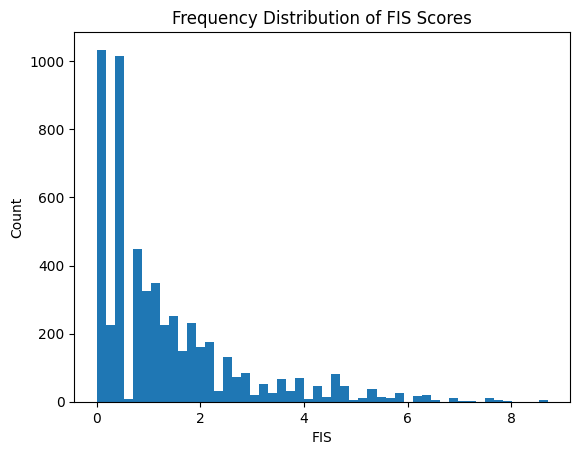

In [151]:
#frequency of scores

scores = list(df2['FIS_score'])
plt.hist(scores, bins=50, )
plt.title('Frequency Distribution of FIS Scores')
plt.xlabel('FIS')
plt.ylabel('Count')

print("The highest recorded score is", max(scores))
print("The lowest recorded score is", min(scores))

#### Spatial Distribution of FIS Scores

In [153]:
#imports
%pip install plotly
import plotly.express as px


     ---------------------------------------- 0.0/16.3 MB ? eta -:--:--
     - -------------------------------------- 0.5/16.3 MB 14.2 MB/s eta 0:00:02
     -- ------------------------------------- 1.1/16.3 MB 14.4 MB/s eta 0:00:02
     ---- ----------------------------------- 2.0/16.3 MB 15.7 MB/s eta 0:00:01
     ------- -------------------------------- 2.9/16.3 MB 18.5 MB/s eta 0:00:01
     --------- ------------------------------ 3.8/16.3 MB 17.1 MB/s eta 0:00:01
     ----------- ---------------------------- 4.6/16.3 MB 18.2 MB/s eta 0:00:01
     ------------- -------------------------- 5.6/16.3 MB 18.7 MB/s eta 0:00:01
     --------------- ------------------------ 6.3/16.3 MB 18.4 MB/s eta 0:00:01
     ----------------- ---------------------- 7.1/16.3 MB 18.2 MB/s eta 0:00:01
     ------------------- -------------------- 8.1/16.3 MB 19.2 MB/s eta 0:00:01
     ---------------------- ----------------- 9.0/16.3 MB 19.3 MB/s eta 0:00:01
     ------------------------ -------------- 10

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
#%pip install jupyterlab
#%pip install notebook
#%pip install geopandas
import geopandas as gpd
#gpd.read_file()


#map = px.choropleth(df2, locations='CZ_FIPS', color='FIS_score', projection='natural earth')
#map.show()

     ---------------------------------------- 0.0/338.0 kB ? eta -:--:--
     ------------------------------------  337.9/338.0 kB 10.6 MB/s eta 0:00:01
     -------------------------------------- 338.0/338.0 kB 7.0 MB/s eta 0:00:00
     ---------------------------------------- 0.0/6.3 MB ? eta -:--:--
     -- ------------------------------------- 0.3/6.3 MB 10.9 MB/s eta 0:00:01
     ----- ---------------------------------- 0.8/6.3 MB 13.4 MB/s eta 0:00:01
     --------- ------------------------------ 1.5/6.3 MB 11.9 MB/s eta 0:00:01
     ------------- -------------------------- 2.2/6.3 MB 12.5 MB/s eta 0:00:01
     ------------------ --------------------- 2.9/6.3 MB 13.2 MB/s eta 0:00:01
     ---------------------- ----------------- 3.5/6.3 MB 13.3 MB/s eta 0:00:01
     -------------------------- ------------- 4.2/6.3 MB 13.4 MB/s eta 0:00:01
     ------------------------------- -------- 5.0/6.3 MB 14.5 MB/s eta 0:00:01
     -------------------------------------- - 6.1/6.3 MB 15.0 MB

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Temporal Distribution of FIS Scores

In [152]:
#calculating average FIS scores across a time range
def avg_FIS_temporal(startyear, endyear):
    '''Returns the average score within the range of startyear to endyear.
    - startyear: int
    - endyear: int

    Returns: int
    '''
    scores = list(df2[['YEAR', 'FIS_score']].apply(lambda x: x['FIS_score'] if x['YEAR']>=startyear and x['YEAR']<=endyear else -1, axis=1))
    scores = [x for x in scores if x!=-1]
    return round(sum(scores)/len(scores), 2)


In [143]:
#average score per five years
five_year = ['1996-2000', '2001-2005', '2006-2010', '2011-2015', '2016-2020', '2021-2024']
five_year_scores = [avg_FIS_temporal(1996, 2000), avg_FIS_temporal(2001, 2005), avg_FIS_temporal(2006, 2010),
avg_FIS_temporal(2011, 2015), avg_FIS_temporal(2016, 2020), avg_FIS_temporal(2021, 2024)]


In [144]:
#calculate average score per year
years = []
for i in range(1996, 2025):
    years.append(i)
year_averages = []
for yr in years:
    year_averages.append(avg_FIS_temporal(yr, yr))

In [146]:
#linear regression line through yearly average FIS scores

#%pip install scikit-learn
from sklearn.linear_model import LinearRegression
model = LinearRegression()
X = [[x] for x in years]
y = [[x] for x in year_averages]
model.fit(X, y)
pred_values = model.predict(X)

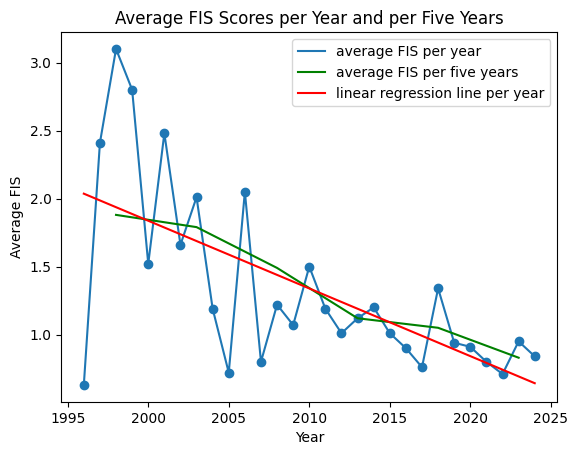

In [148]:
#plotting the lines

plt.plot(years, year_averages) #actual values per year
median_years = [1998, 2003, 2008, 2013, 2018, 2023]
plt.plot(median_years, five_year_scores, color="green") #actual values per FIVE years
plt.plot(years, pred_values, color='red') #linear regression line per year
plt.scatter(years, year_averages) #actual point values per year

plt.xlabel("Year")
plt.ylabel("Average FIS")
plt.title("Average FIS Scores per Year and per Five Years")
plt.legend(['average FIS per year','average FIS per five years','linear regression line per year'])